In [1]:
import optuna
from optuna.trial import Trial
import optuna.visualization as vis
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import pyrcn
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from chex import Array, Scalar
from typing import Tuple

from esn import ESN
from utils import chunkify, plot_predictions

key = jax.random.PRNGKey(43)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


# Data

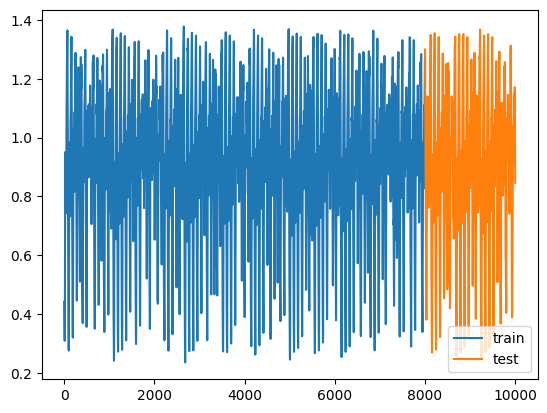

X train-test shapes: (10, 7990)	(10, 1990)
Y train-test shapes: (1, 7990)	(1, 1990)


In [2]:
N_SAMPLES = 10000
SPLIT_RATIO = 0.8
HISTORY_LEN = 10
FORECAST_LEN = 1

# Load from csv file
mackey_data = jnp.squeeze(jnp.array(pd.read_csv("data/MackeyGlass_10k.csv", index_col=0)))
# mackey_data = jnp.linspace(-1, 1, n_samples)

# Split into train-test
split = int(SPLIT_RATIO * N_SAMPLES)
mackey_train = mackey_data[:split]
mackey_test = mackey_data[split:]

# Plot
plt.plot(jnp.arange(0, split, dtype=jnp.int32), mackey_train, label="train")
plt.plot(jnp.arange(split, N_SAMPLES, dtype=jnp.int32), mackey_test, label="test")
plt.legend()
plt.show()

# Split into input and output
X_train, Y_train = chunkify(mackey_train, HISTORY_LEN, FORECAST_LEN)
X_test, Y_test = chunkify(mackey_test, HISTORY_LEN, FORECAST_LEN)

X_train_np, Y_train_np = np.array(X_train), np.array(Y_train)
X_test_np, Y_test_np = np.array(X_test), np.array(Y_test)

print(f"X train-test shapes: {X_train.shape}\t{X_test.shape}")
print(f"Y train-test shapes: {Y_train.shape}\t{Y_test.shape}")

# My ESN

## Optuna Search 

In [3]:
def objective(trial: Trial) -> Scalar:

    # Define hyperparameters
    hn = trial.suggest_int("hidden_nodes", 10, 1000, log=True)
    # si = trial.suggest_float("sparsity_in", 0.0, 1.0)
    # sn = trial.suggest_float("sparsity_node", 0.0, 1.0)
    # sr = trial.suggest_float("spectral_radius", 0.0, 1.0)
    l = trial.suggest_float("leakage", 0.0, 1.0)
    l2 = trial.suggest_float("l2_cost", 0.1, 1000.0, log=True)

    # Create the model
    my_ESN = ESN(
        jax.random.PRNGKey(72),
        hidden_nodes=hn,
        sparsity_in=1.0,
        sparsity_node=1.0,
        input_activation=lambda x: x,
        node_activation=jax.nn.relu,
        spectral_radius=1.0,
        leakage=l,
        l2_cost=l2
    )

    # Train and evaluate the model
    y_hat_train = my_ESN.fit(X_train, Y_train)
    mse_train = mean_squared_error(Y_train, y_hat_train)

    return mse_train

In [4]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-08-09 15:28:16,826] A new study created in memory with name: no-name-58195a46-2ec2-47b4-9d60-8c9dbf539b46
[I 2023-08-09 15:28:17,819] Trial 0 finished with value: 595.2156982421875 and parameters: {'hidden_nodes': 30, 'leakage': 0.3819030577621718, 'l2_cost': 214.79229077354734}. Best is trial 0 with value: 595.2156982421875.
[I 2023-08-09 15:28:18,244] Trial 1 finished with value: 89.7957992553711 and parameters: {'hidden_nodes': 11, 'leakage': 0.09327607980828279, 'l2_cost': 389.06979150836594}. Best is trial 1 with value: 89.7957992553711.
[I 2023-08-09 15:28:19,149] Trial 2 finished with value: 0.5636608004570007 and parameters: {'hidden_nodes': 34, 'leakage': 0.9213476321588723, 'l2_cost': 0.1357124626983881}. Best is trial 2 with value: 0.5636608004570007.
[I 2023-08-09 15:28:19,791] Trial 3 finished with value: 14167.78125 and parameters: {'hidden_nodes': 10, 'leakage': 0.7748128526257089, 'l2_cost': 0.17677782099725284}. Best is trial 2 with value: 0.5636608004570007.
[

In [9]:
# Evaluating our Optuna Trial
print("Best trial:", study.best_trial.number)
print("Best accuracy:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best trial: 79
Best accuracy: 0.0671621710062027
Best hyperparameters: {'hidden_nodes': 14, 'leakage': 0.7867086239533064, 'l2_cost': 0.1800606845001689}


In [10]:
optimization_history_plot = vis.plot_optimization_history(study, error_bar=True)
optimization_history_plot.show()

In [11]:
# Plotting a Contour Plot in Optuna
contour_plot = vis.plot_contour(study, params=["hidden_nodes"])
contour_plot.show()

[W 2023-08-09 15:29:43,205] The length of params must be greater than 1.


## Evaluation

In [13]:
# Create the model
my_ESN = ESN(
    jax.random.PRNGKey(72),
    hidden_nodes=14,
    sparsity_in=1.0,
    sparsity_node=1.0,
    input_activation=lambda x: x,
    node_activation=jax.nn.relu,
    spectral_radius=1.0,
    leakage=0.7867086239533064,
    l2_cost=0.1800606845001689
)

# Train and evaluate the model
y_hat_train = my_ESN.fit(X_train, Y_train)
mse_train = mean_squared_error(Y_train, y_hat_train)
print(f"MSE train: {mse_train}")

MSE train: 0.0671621710062027


In [15]:
X_train.shape, Y_train.shape, y_hat_train.shape

((10, 7990), (1, 7990), (1, 7990))

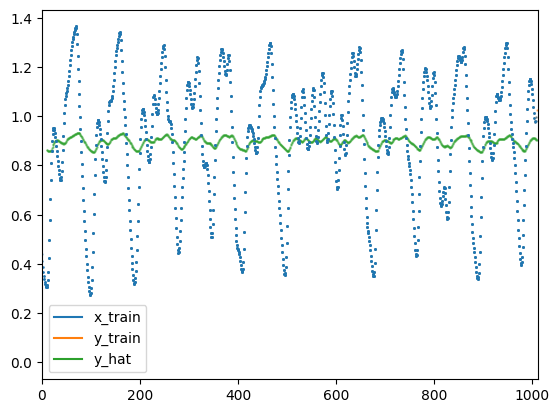

In [18]:
n_first = 1000
plot_predictions(X_train[:, :n_first], Y_train[:, :n_first], y_hat_train[:, :n_first], HISTORY_LEN, FORECAST_LEN)

# PyRCN

## Optuna Search

In [18]:
def objective(trial: Trial) -> Scalar:

    # Define hyperparameters
    hn = trial.suggest_int("hidden_nodes", 10, 1000, log=True)
    # si = trial.suggest_float("sparsity_in", 0.0, 1.0)
    # sn = trial.suggest_float("sparsity_node", 0.0, 1.0)
    # sr = trial.suggest_float("spectral_radius", 0.0, 1.0)
    l = trial.suggest_float("leakage", 0.0, 1.0)
    l2 = trial.suggest_float("l2_cost", 0.1, 1000.0, log=True)

    # Create the model
    input_to_node = InputToNode(
        hidden_layer_size=hn,
        k_in=None,
        sparsity=1.0,
        input_activation="identity",
    )
    node_to_node = NodeToNode(
        hidden_layer_size=hn,
        sparsity=1.0,
        reservoir_activation="tanh",
        spectral_radius=1.0,
        leakage=l,
        bidirectional=False
    )

    R_i2n = input_to_node.fit_transform(X_train_np.T)
    R_n2n = node_to_node.fit_transform(R_i2n)
    ridge_train = Ridge(alpha=l2).fit(R_n2n, np.squeeze(Y_train_np))

    # Train and evaluate the model
    y_hat_train_pyrcn = ridge_train.predict(R_n2n)
    mse_train_pyrcn = mean_squared_error(Y_train.T, y_hat_train_pyrcn)

    return mse_train_pyrcn

In [ ]:
study_pyrcn = optuna.create_study(direction="minimize")
study_pyrcn.optimize(objective, n_trials=100, timeout=10)

In [20]:
# Evaluating our Optuna Trial
print("Best trial:", study_pyrcn.best_trial.number)
print("Best accuracy:", study_pyrcn.best_trial.value)
print("Best hyperparameters:", study_pyrcn.best_params)

Best trial: 0
Best accuracy: 0.00041798065588513644
Best hyperparameters: {'hidden_nodes': 41, 'leakage': 0.8827877336070363, 'l2_cost': 1.2451100546813814}


In [21]:
contour_plot = vis.plot_contour(study_pyrcn, params=["hidden_nodes", "leakage"])
contour_plot.show()